In [1]:
%%capture
!git clone https://github.com/davidtvs/pytorch-lr-finder.git && cd pytorch-lr-finder && python setup.py install

In [5]:
!pip install transformers tokenizers pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 9.1 MB/s 
     |████████████████████████████████| 6.6 MB 55.1 MB/s 
     |████████████████████████████████| 706 kB 73.5 MB/s 
     |████████████████████████████████| 120 kB 65.5 MB/s 
     |████████████████████████████████| 419 kB 69.9 MB/s 
     |████████████████████████████████| 5.9 MB 64.2 MB/s 
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.10.0 which is incompatible.


In [1]:
import torch
from torch import nn
from typing import List
import torch.nn.functional as F
from transformers import DistilBertTokenizer, AutoTokenizer, AutoModelWithLMHead, DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import logging
import os
from functools import lru_cache
from tokenizers import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from argparse import Namespace
from sklearn.metrics import classification_report
torch.__version__

'1.12.1+cu113'

In [2]:
tokenizer = AutoTokenizer.from_pretrained('distilroberta-base')      #tokenizor of Roberta

In [3]:
model = AutoModelWithLMHead.from_pretrained("distilroberta-base")
base_model = model.base_model

/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:1002: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


In [4]:
text = "Elvis is the king of rock!"
enc = tokenizer.encode_plus(text)
enc.keys()

dict_keys(['input_ids', 'attention_mask'])

In [5]:
print(enc)

{'input_ids': [0, 9682, 9578, 16, 5, 8453, 9, 3152, 328, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [6]:
out = base_model(torch.tensor(enc["input_ids"]).unsqueeze(0), torch.tensor(enc["attention_mask"]).unsqueeze(0))
out[0].shape

torch.Size([1, 10, 768])

In [7]:
## size of representation of one of the tokens 
out[0][:,0,:].shape

torch.Size([1, 768])

In [8]:
t = "Elvis is the king of rock"
enc = tokenizer.encode_plus(t)
token_representations = base_model(torch.tensor(enc["input_ids"]).unsqueeze(0))[0][0]
print(enc["input_ids"])
print(tokenizer.decode(enc["input_ids"]))
print(f"Length: {len(enc['input_ids'])}")
print(token_representations.shape)

[0, 9682, 9578, 16, 5, 8453, 9, 3152, 2]
<s>Elvis is the king of rock</s>
Length: 9
torch.Size([9, 768])


In [9]:

@torch.jit.script
def mish(input):
    return input * torch.tanh(F.softplus(input))
  
class Mish(nn.Module):
    def forward(self, input):
        return mish(input)

In [10]:
class EmoModel(nn.Module):
    def __init__(self, base_model, n_classes, base_model_output_size=768, dropout=0.05):
        super().__init__()
        self.base_model = base_model
        
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, base_model_output_size),
            Mish(),
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, n_classes)
        )
        
        for layer in self.classifier:
            if isinstance(layer, nn.Linear):
                layer.weight.data.normal_(mean=0.0, std=0.02)
                if layer.bias is not None:
                    layer.bias.data.zero_()

    def forward(self, input_, *args):
        X, attention_mask = input_
        hidden_states = self.base_model(X, attention_mask=attention_mask)
        
        # maybe do some pooling / RNNs... go crazy here!
        
        # use the <s> representation
        return self.classifier(hidden_states[0][:, 0, :])

In [11]:
classifier = EmoModel(AutoModelWithLMHead.from_pretrained("distilroberta-base").base_model, 3)

In [12]:
X = torch.tensor(enc["input_ids"]).unsqueeze(0).to('cpu')
attn = torch.tensor(enc["attention_mask"]).unsqueeze(0).to('cpu')

In [13]:
classifier((X, attn))

tensor([[-0.0127,  0.1220,  0.0358]], grad_fn=<AddmmBackward0>)

In [14]:
!mkdir -p tokenizer

In [15]:
## load pretrained tokenizer information
tokenizer.save_pretrained("tokenizer")

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/vocab.json',
 'tokenizer/merges.txt',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

In [16]:
!ls tokenizer

merges.txt		 tokenizer_config.json	vocab.json
special_tokens_map.json  tokenizer.json


In [17]:
class TokenizersCollateFn:
    def __init__(self, max_tokens=512):

        ## RoBERTa uses BPE tokenizer similar to GPT
        t = ByteLevelBPETokenizer(
            "tokenizer/vocab.json",
            "tokenizer/merges.txt"
        )
        t._tokenizer.post_processor = BertProcessing(
            ("</s>", t.token_to_id("</s>")),
            ("<s>", t.token_to_id("<s>")),
        )
        t.enable_truncation(max_tokens)
        t.enable_padding(length=max_tokens, pad_id=t.token_to_id("<pad>"))
        self.tokenizer = t

    def __call__(self, batch):
        encoded = self.tokenizer.encode_batch([x[0] for x in batch])
        sequences_padded = torch.tensor([enc.ids for enc in encoded])
        attention_masks_padded = torch.tensor([enc.attention_mask for enc in encoded])
        labels = torch.tensor([x[1] for x in batch])
        
        return (sequences_padded, attention_masks_padded), labels

In [18]:
!wget https://www.dropbox.com/s/ikkqxfdbdec3fuj/test.txt
!wget https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt
!wget https://www.dropbox.com/s/2mzialpsgf9k5l3/val.txt

--2022-09-12 15:28:43--  https://www.dropbox.com/s/ikkqxfdbdec3fuj/test.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/ikkqxfdbdec3fuj/test.txt [following]
--2022-09-12 15:28:43--  https://www.dropbox.com/s/raw/ikkqxfdbdec3fuj/test.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2de113bc5fd4f711517140bbd0.dl.dropboxusercontent.com/cd/0/inline/Bs2PtXxZdgW1Ie23K6tTu8DEJH2Ww5c_pFw4sb24a-6Yt1ul4k0gkV9jnfEqYFxBfXiWCd6RNERwuLhaGB1YkuF8VzBbeB_EaP5WhQR5j_pAR-lllKqcKE9wbQlKnXScj8kZJR_dOFKQq1U-E6YLUFHyxrtdFnhY15clu3XoHnXTpQ/file# [following]
--2022-09-12 15:28:43--  https://uc2de113bc5fd4f711517140bbd0.dl.dropboxusercontent.com/cd/0/inline/Bs2PtXxZdgW1Ie23K6tTu8DEJH2Ww5c_pFw4sb24a-6Yt1ul4k0gkV9jnfEqYFxBfXiWCd6RNERwuLhaGB1YkuF8VzBb

In [19]:
## export the datasets as txt files
## EXERCISE: Change this to an address

train_path = "train.txt"
test_path = "test.txt"
val_path = "val.txt"

## emotion labels
label2int = {
  "sadness": 0,
  "joy": 1,
  "love": 2,
  "anger": 3,
  "fear": 4,
  "surprise": 5
}

emotions = [ "sadness", "joy", "love", "anger", "fear", "surprise"]

In [20]:
!wget https://www.dropbox.com/s/607ptdakxuh5i4s/merged_training.pkl

--2022-09-12 15:28:47--  https://www.dropbox.com/s/607ptdakxuh5i4s/merged_training.pkl
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/607ptdakxuh5i4s/merged_training.pkl [following]
--2022-09-12 15:28:47--  https://www.dropbox.com/s/raw/607ptdakxuh5i4s/merged_training.pkl
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc604859856401a35a6c2b3c6812.dl.dropboxusercontent.com/cd/0/inline/Bs2Dgk-MJqMocTylYLvEEHNtwE_qMAPzCApBrxteWoU0AXTvhRPE99mAy8rvl4bDA7_qFjqtHs7f5wQizNQZxgTq2uDT-YXMznIo8qWhz2hMjr9LKf9snbs4mmVSEIoEZ_8gDuvUjXJifIjXrcWWxNiDUSnfh82IRTonNR1oMCquIQ/file# [following]
--2022-09-12 15:28:47--  https://uc604859856401a35a6c2b3c6812.dl.dropboxusercontent.com/cd/0/inline/Bs2Dgk-MJqMocTylYLvEEHNtwE_qMAPzCApBrxteWoU0AXTvhRPE99mAy8r

In [21]:
import pickle

## helper function
def load_from_pickle(directory):
    return pickle.load(open(directory,"rb"))

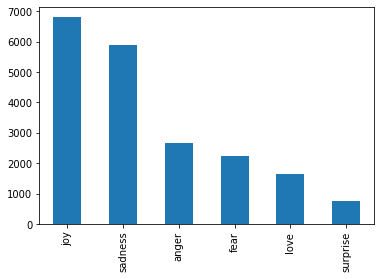

In [22]:
data = load_from_pickle(directory="merged_training.pkl")

## using a sample
data= data[data["emotions"].isin(emotions)]


data = data.sample(n=20000);

data.emotions.value_counts().plot.bar()

In [23]:
data.count()

text        20000
emotions    20000
dtype: int64

In [24]:
data.head()

,text,emotions
17866,i feel particularly tortured over a decision t...,fear
53885,i feel more joyful than i ve ever felt more fu...,joy
40250,i feel like i am doomed to screw up all relati...,sadness
85253,i question if feeling so drained and exhausted...,sadness
34305,i feel delighted everytime i talk to that person,joy


In [25]:
## reset index
data.reset_index(drop=True, inplace=True)

In [26]:
## check unique emotions in the dataset
data.emotions.unique()

array(['fear', 'joy', 'sadness', 'anger', 'love', 'surprise'],
      dtype=object)

In [28]:
class EmoDataset(Dataset):
    def __init__(self, path):
        super().__init__()
        self.data_column = "text"
        self.class_column = "class"
        self.data = pd.read_csv(path, sep=";", header=None, names=[self.data_column, self.class_column],
                               engine="python")

    def __getitem__(self, idx):
        return self.data.loc[idx, self.data_column], label2int[self.data.loc[idx, self.class_column]]

    def __len__(self):
        return self.data.shape[0]

In [29]:
ds = EmoDataset(train_path)
ds[19]

('i now feel compromised and skeptical of the value of every unit of work i put in',
 4)

In [30]:
## Methods required by PyTorchLightning

class TrainingModule(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.model = EmoModel(AutoModelWithLMHead.from_pretrained("distilroberta-base").base_model, len(emotions))
        self.loss = nn.CrossEntropyLoss() ## combines LogSoftmax() and NLLLoss()
        #self.hparams = hparams
        self.hparams.update(vars(hparams))

    def step(self, batch, step_name="train"):
        X, y = batch
        loss = self.loss(self.forward(X), y)
        loss_key = f"{step_name}_loss"
        tensorboard_logs = {loss_key: loss}

        return { ("loss" if step_name == "train" else loss_key): loss, 'log': tensorboard_logs,
               "progress_bar": {loss_key: loss}}

    def forward(self, X, *args):
        return self.model(X, *args)

    def training_step(self, batch, batch_idx):
        return self.step(batch, "train")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, "val")

    def validation_end(self, outputs: List[dict]):
        loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        return {"val_loss": loss}
        
    def test_step(self, batch, batch_idx):
        return self.step(batch, "test")
    
    def train_dataloader(self):
        return self.create_data_loader(self.hparams.train_path, shuffle=True)

    def val_dataloader(self):
        return self.create_data_loader(self.hparams.val_path)

    def test_dataloader(self):
        return self.create_data_loader(self.hparams.test_path)
                
    def create_data_loader(self, ds_path: str, shuffle=False):
        return DataLoader(
                    EmoDataset(ds_path),
                    batch_size=self.hparams.batch_size,
                    shuffle=shuffle,
                    collate_fn=TokenizersCollateFn()
        )
        
    @lru_cache()
    def total_steps(self):
        return len(self.train_dataloader()) // self.hparams.accumulate_grad_batches * self.hparams.epochs

    def configure_optimizers(self):
        ## use AdamW optimizer -- faster approach to training NNs
        ## read: https://www.fast.ai/2018/07/02/adam-weight-decay/
        optimizer = AdamW(self.model.parameters(), lr=self.hparams.lr)
        lr_scheduler = get_linear_schedule_with_warmup(
                    optimizer,
                    num_warmup_steps=self.hparams.warmup_steps,
                    num_training_steps=self.total_steps(),
        )
        return [optimizer], [{"scheduler": lr_scheduler, "interval": "step"}]

/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:1002: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.99E-04


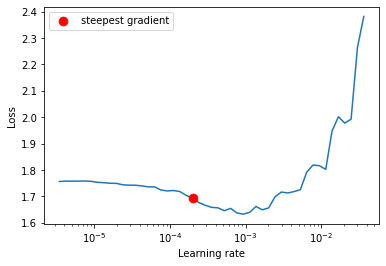

In [31]:
lr=0.1 ## uper bound LR
from torch_lr_finder import LRFinder
hparams_tmp = Namespace(
    train_path=train_path,
    val_path=val_path,
    test_path=test_path,
    batch_size=16,
    warmup_steps=100,
    epochs=1,
    lr=lr,
    accumulate_grad_batches=1,
)
module = TrainingModule(hparams_tmp)
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(module.parameters(), lr=5e-7) ## lower bound LR
lr_finder = LRFinder(module, optimizer, criterion, device="cuda")
lr_finder.range_test(module.train_dataloader(), end_lr=100, num_iter=100, accumulation_steps=hparams_tmp.accumulate_grad_batches)
lr_finder.plot()
lr_finder.reset()

In [32]:
lr = 1e-4 
lr

0.0001

LR suggestion: steepest gradient
Suggested LR: 1.99E-04


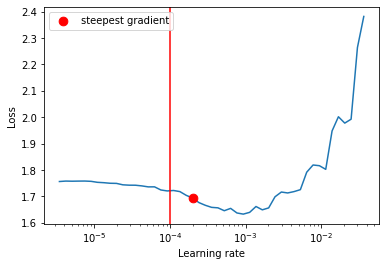

(<matplotlib.axes._subplots.AxesSubplot at 0x7fbd8aa1b3d0>,
 0.00019873869201792927)

In [33]:
lr_finder.plot(show_lr=lr)

In [34]:
hparams = Namespace(
    train_path=train_path,
    val_path=val_path,
    test_path=test_path,
    batch_size=32,
    warmup_steps=100,
    epochs=1,
    lr=lr,
    accumulate_grad_batches=1
)
module = TrainingModule(hparams)

In [35]:
## garbage collection
import gc; gc.collect()
torch.cuda.empty_cache()

In [37]:
## train roughly for about 10-15 minutes with GPU enabled.
trainer = pl.Trainer(gpus=1, max_epochs=hparams.epochs,
                     accumulate_grad_batches=hparams.accumulate_grad_batches)

trainer.fit(module)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | EmoModel         | 82.1 M
1 | loss  | CrossEntropyLoss | 0     
-----------------------------------

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [39]:
with torch.no_grad():
    progress = ["/", "-", "\\", "|", "/", "-", "\\", "|"]
    module.eval()
    true_y, pred_y = [], []
    for i, batch_ in enumerate(module.test_dataloader()):
        (X, attn), y = batch_
        batch = (X.cpu(), attn.cpu())
        print(progress[i % len(progress)], end="\r")
        y_pred = torch.argmax(module(batch), dim=1)
        true_y.extend(y.cpu())
        pred_y.extend(y_pred.cpu())
print("\n" + "_" * 80)
print(classification_report(true_y, pred_y, target_names=label2int.keys(), digits=len(emotions)))


________________________________________________________________________________
              precision    recall  f1-score   support

     sadness   0.949580  0.972461  0.960884       581
         joy   0.973765  0.907914  0.939687       695
        love   0.736318  0.930818  0.822222       159
       anger   0.953846  0.901818  0.927103       275
        fear   0.879828  0.915179  0.897155       224
    surprise   0.793651  0.757576  0.775194        66

    accuracy                       0.923500      2000
   macro avg   0.881165  0.897628  0.887041      2000
weighted avg   0.928659  0.923500  0.924584      2000



In [40]:
!nvidia-smi

Mon Sep 12 16:14:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    34W /  70W |   1004MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

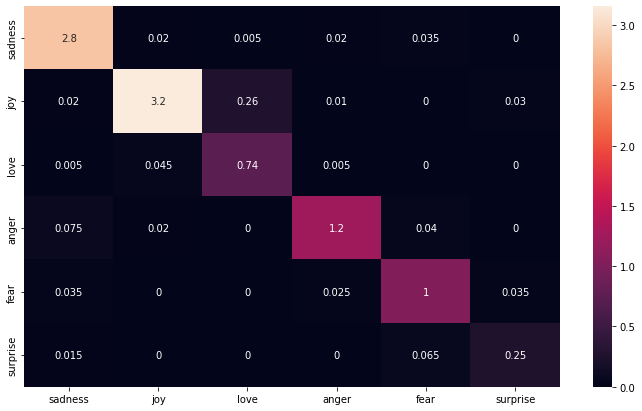

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# constant for classes
classes = ( "sadness", "joy", "love", "anger", "fear", "surprise")

# Build confusion matrix
cf_matrix = confusion_matrix(true_y, pred_y)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('confusion_matrix.png')

In [42]:
diff_y = [0]*2000
for i in range(2000):
  if true_y[i].tolist() == pred_y[i].tolist():
    diff_y[i] = 0
  else:
    diff_y[i] = 1

all_errors = sum(diff_y)
rough_accuracy = ((2000-all_errors)/2000) * 100
print(f"The rough accuracy is {rough_accuracy}% as we spotted {all_errors} in our validation set of 2000 datas.")

The rough accuracy is 92.35% as we spotted 153 in our validation set of 2000 datas.


In [43]:
def test_model(my_model,test_sentence1):
  enc1 = tokenizer.encode_plus(test_sentence1)
  X = torch.tensor(enc1["input_ids"]).unsqueeze(0).to('cpu')
  attn = torch.tensor(enc1["attention_mask"]).unsqueeze(0).to('cpu')

  index = torch.argmax(my_model((X,attn))).tolist()
  print(emotions[index])


In [ ]:
def detail_test(my_model,test_sentence1):
  enc1 = tokenizer.encode_plus(test_sentence1)
  X = torch.tensor(enc1["input_ids"]).unsqueeze(0).to('cpu')
  attn = torch.tensor(enc1["attention_mask"]).unsqueeze(0).to('cpu')

  all_classification = torch(my_model((X,attn))).tolist()
  classification = []

  for i in range(6):
    classification.append([emotions[i],[all_classification[i]*100]])

  print(classification)

In [44]:
test_model(module, 'What a lovely day it is!')
test_model(module, 'How could she do that to me?')
test_model(module, 'Look what you made me do.')


love
anger
anger


In [ ]:
torch.save(module,'/contents/analyzer_model.h5')